In [1]:
!apt update
!apt-get install libglu1 -y
!pip install kornia_moons --upgrade
!pip install opencv-python
!pip install opencv-contrib-python
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install pydegensac

Get:1 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:5 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:8 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [29.4 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1096 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1142 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2060 kB]
Get:13 http://archive.ubuntu.com/ubuntu foca

In [ ]:
!pip install git+https://github.com/kornia/kornia

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-buf8f3tt
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-buf8f3tt
  Resolved https://github.com/kornia/kornia to commit ec97d28d36501d8b57362ef8f4a964bfd41f2778
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=dd3e57838559e1d61409c6554cdce7ca7fc889be41c2757e85e1405f0501dd10
  Stored in directory: /tmp/pip-ephem-wheel-cache-8f1hxe4p/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [ ]:
import pydegensac
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
from ipywidgets import FloatProgress
import time
import imutils

def resize(scale,img):
    scale_percent = scale  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized

def load_torch_image(fname,s, rot=0):
    img= cv2.imread(fname)
    if rot!=0:
        img = imutils.rotate_bound(img, rot)
    img=resize(s,img)
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img


In [ ]:
start=time.time()
fname1 = '../../Data/3D_sim_tests/newLS_drone_3Drot_3_highQ.png'#NewLSTemplates/newLS_drone_2_lowQ.jpg
fname2 = '../../Data/NewLSTemplates/newLS_sat_4-4_highQ.png'#'rectified.jpg'
acc=[0,0,0,0]
true_inliers=[]
f_mkpoints=[]
for t in range(4):

    img1 = load_torch_image(fname1,25,0+90*t)
    img2 = load_torch_image(fname2,25)


    matcher = KF.LoFTR(pretrained='outdoor')

    input_dict = {"image0": K.color.rgb_to_grayscale(img1), # LofTR works on grayscale images only 
                  "image1": K.color.rgb_to_grayscale(img2)}

    with torch.no_grad():
        correspondences = matcher(input_dict)
    print(f"{t*90} >0.5: {torch.count_nonzero(correspondences['confidence']>0.5)};", end='')
    print(f"{t*90} avg: {torch.mean(correspondences['confidence'])};", end='')
    if(torch.mean(correspondences['confidence'])<0.3):
        true_inliers.append([])
        f_mkpoints.append([])
        print()
        continue
        
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    f_mkpoints.append([mkpts0, mkpts1])
    H1, inliers1 = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.9999, 100000)
    inliers1 = inliers1 > 0
    H2, inliers2 = pydegensac.findFundamentalMatrix(mkpts0, mkpts1, 0.5)
    print(f'{t*90}: {np.count_nonzero(inliers1 == True)};', end='')
    print(f'{t*90}: {np.count_nonzero(inliers2 == True)};')
    inliers_i= []
    for i,k in enumerate(inliers1):
        if(k[0]==True and inliers2[i]==True):
            inliers_i.append(True)
            acc[t]+=1
        else:
            inliers_i.append(False)
    true_inliers.append(inliers_i)
    if acc[t]>20:
        break

f=acc.index(max(acc))
n_img1 = load_torch_image(fname1,30,0+90*f)
inliers=np.array(true_inliers[f])
n_mkpts0=np.array(f_mkpoints[f][0])
n_mkpts1=np.array(f_mkpoints[f][1])
end=time.time()
print(f'Time after time: {end-start}')

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


  0%|          | 0.00/44.2M [00:00<?, ?B/s]

/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

0 >0.5: 10;0 avg: 0.32729941606521606;0: 12;0: 12;
90 >0.5: 12;90 avg: 0.3400100767612457;90: 14;90: 12;
180 >0.5: 13;180 avg: 0.37039849162101746;180: 14;180: 13;
270 >0.5: 12;270 avg: 0.34308600425720215;270: 15;270: 13;
Time after time: 49.13846302032471


In [ ]:
print(f)
print(len(n_mkpts1))
print(len(inliers))
print(acc)

2
69
69
[3, 1, 4, 1]


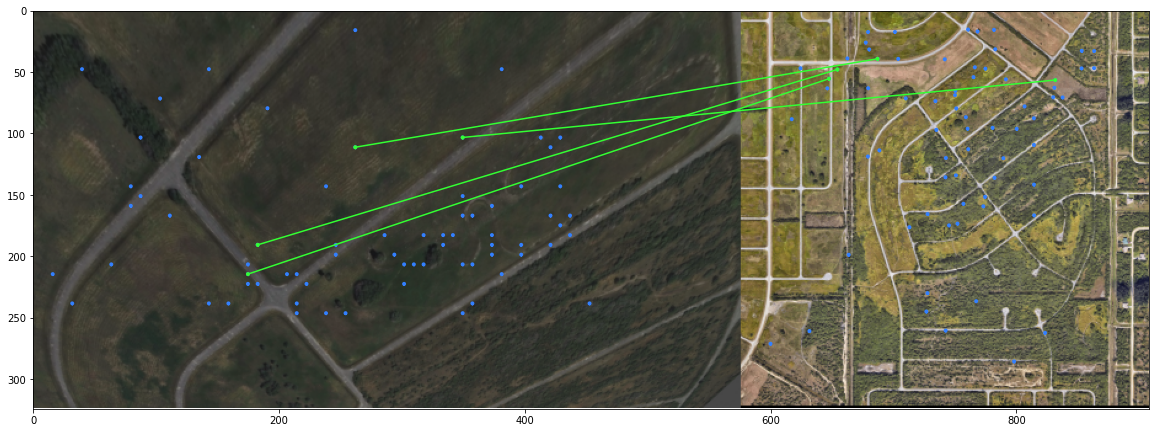

In [ ]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(n_mkpts0).view(1,-1, 2),
                                torch.ones(n_mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(n_mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(n_mkpts1).view(1,-1, 2),
                                torch.ones(n_mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(n_mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(n_mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(n_img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})